# PEFT

Сегодня LLM становятся незаменимым инструментом как для полноценного решения продуктовых задач, так и на промежуточных этапах, например, генерация разметки или создание синтетических датасетов. Обучение и дообучение таких моделей может быть ресурсозатратным, поэтому на зачастую полезно использовать Parameter-Efficient Fine-Tuning, PEFT.

PEFT позволяет адаптировать крупные языковые модели под конкретные задачи, внося минимальные изменения в архитектуру и обучаясь на сравнительно небольшом объёме данных. Ключевые методы – такие как адаптеры, LoRA или DoRA – демонстрируют высокую эффективность, позволяя достичь конкурентоспособной точности при низких затратах на вычислительные мощности.

Представьте, что ваша задача – определить тональность твитов. Твиты – короткие, насыщенные эмоциями и часто саркастичные сообщения, где традиционные модели могут давать сбои из-за неформального стиля и ограниченного контекста. Используя PEFT, вы можете донастроить LLM под особенности твиттер-лексикона, адаптируя модель на небольшом, но репрезентативном наборе данных.

## Импортируем зависимости

In [ ]:
%pip install --quiet datasets bitsandbytes trl peft sentencepiece


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import gc
import os
import random
import re
from functools import partial

import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, interpreter_login
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from trl import SFTTrainer

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-04-12 17:56:20.235667: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appr

In [ ]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



Enter your token (input will not be visible):  ········
Add token as git credential? (Y/n)  n


In [ ]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw3"  # Или как вам хочется

SEED = 42

print(f"Homework repository: '{REPO_NAME}'")

Homework repository: 'gsemenyak/llm-course-hw3'


In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)
def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

set_seed(SEED)
print(f"{DEVICE=}")

DEVICE='cuda'


В качестве базовой модели возьмем [`Lite-Oute-1-300M-Instruct`](https://huggingface.co/OuteAI/Lite-Oute-1-300M-Instruct).
Она использует за основу Mistral и насчитывает около 300 млн параметров, размер контекста до 4096 токенов.

Вы можете использовать любую другую модель, однако обратите внимание, что используете на `Instruct` версию.

In [ ]:
MODEL_NAME = "OuteAI/Lite-Oute-1-300M-Instruct"

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

## Подготовка данных [2 балла]

Думаю, вы уже задумались над тем, что качество датасета для модели такого размера будет заметно влиять на перфоманс модели после обучения. Это действительно так, более того есть интересное исследование и на больших моделях: [LIMA: Less Is More for Alignment](https://arxiv.org/abs/2305.11206) показывает, что даже большие модели (например, Llama 65B) можно успешно обучить на небольшом, но исключительно качественном наборе данных.

Для нашей задачи воспользуемся стандартным датасетом классификации твиттов по тональности: [`cardiffnlp/tweet_eval`](https://huggingface.co/datasets/cardiffnlp/tweet_eval).

In [ ]:
dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")

IDX2NAME = {0: "negative", 1: "neutral", 2: "positive"}


def add_str_label(example):
    example["str_label"] = IDX2NAME[example["label"]]
    return example


for split, data in dataset.items():
    dataset[split] = data.map(add_str_label)

for i in range(5):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
text: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
label: 1
str_label: neutral
text: Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
label: 1
str_label: neutral
text: Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
label: 1
str_label: neutral
text: @user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
label: 2
str_label: positive


Для подготовки датасета необходими

1. Задать системный промпт, в нем полезно описать задачу, а также определить формат генерации. В нашем случае это одно слово – название класса.
2. Задать пользовательский промпт, в котором будет находиться текст на классификацию.
3. Применить `chat_template` с помощью метода `tokenizer.apply_chat_template`, добавить начало генерации ассистента.
4. Токенизировать датасет.

In [ ]:
SYSTEM_PROMPT = """
Classify user's text.
Answer ONLY ONE word in the ONLY ONE line and no more before and after.
No repetitions, no additional new lines.
Answer can be: positive, neutral or negative.
""".strip().replace("\n", " ")

print(f"{SYSTEM_PROMPT=}")


def process_example(example, *, tokenizer, system_prompt=SYSTEM_PROMPT):
    """Pprocesses a single example by constructing a chat-based prompt and tokenizing it.

    Process:
        1. Constructs a conversation comprising three roles:
            - "system": Provides instructions for classifying the sentiment.
            - "user": Presents the input message.
            - "assistant": Contains the expected sentiment answer.
        2. Applies the chat template to generate the full prompt.

    Parameters:
        example (dict): A dictionary with keys:
            - 'text': The message to be classified.
            - 'str_label': The expected sentiment label.
        system_prompt (str): System prompt to use

    Returns:
        dict: Extended dictionary containing conversational prompts:
            - 'prompt': Input task
            - 'full_prompt': Full conversation including task label
    """
    # todo()
    conversation = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": example["text"]},
        {"role": "assistant", "content": example["str_label"]}
    ]
    full_prompt = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=False)
    prompt = full_prompt.split("<|im_start|>assistant\n")[0] + "<|im_start|>assistant\n"
    if not full_prompt.endswith(tokenizer.eos_token):
         full_prompt += tokenizer.eos_token
    return {"prompt": prompt, "full_prompt": full_prompt}

SYSTEM_PROMPT="Classify user's text. Answer ONLY ONE word in the ONLY ONE line and no more before and after. No repetitions, no additional new lines. Answer can be: positive, neutral or negative."


In [ ]:
for split, data in dataset.items():
    dataset[split] = data.map(process_example, fn_kwargs={"tokenizer": tokenizer})

for i in range(2):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
prompt: <|im_start|>system
Classify user's text. Answer ONLY ONE word in the ONLY ONE line and no more before and after. No repetitions, no additional new lines. Answer can be: positive, neutral or negative.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant

full_prompt: <|im_start|>system
Classify user's text. Answer ONLY ONE word in the ONLY ONE line and no more before and after. No repetitions, no additional new lines. Answer can be: positive, neutral or negative.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant
positive<|im_end|>
<|im_end|>
text: "Ben Smith / Smith (concussio

In [ ]:
def tokenization(example, *, tokenizer, max_length=256):
    """Tokenize both prompt and full prompt and
    save result in `input_ids` and `full_input_ids` keys along with original keys
    """
    # todo()
    prompt_ids = tokenizer(example["prompt"], truncation=True, max_length=max_length, padding=False)["input_ids"]
    full_prompt_ids = tokenizer(example["full_prompt"], truncation=True, max_length=max_length, padding=False)["input_ids"]
    return {**example, "input_ids": prompt_ids, "full_input_ids": full_prompt_ids}

for split, data in dataset.items():
    dataset[split] = data.map(tokenization, batched=True, fn_kwargs={"tokenizer": tokenizer})

for i in range(2):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
prompt: <|im_start|>system
Classify user's text. Answer ONLY ONE word in the ONLY ONE line and no more before and after. No repetitions, no additional new lines. Answer can be: positive, neutral or negative.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant

full_prompt: <|im_start|>system
Classify user's text. Answer ONLY ONE word in the ONLY ONE line and no more before and after. No repetitions, no additional new lines. Answer can be: positive, neutral or negative.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant
positive<|im_end|>
<|im_end|>
input_ids: [1, 32001, 1587, 13, 247

Попробуем решить задачу исходной моделью!

In [ ]:
def generate_class(model, tokenizer, input_ids):
    output_ids = model.generate(input_ids, max_new_tokens=16)
    generated_text = tokenizer.decode(output_ids[0][len(input_ids[0]) :], skip_special_tokens=True)
    return generated_text


for i in range(5):
    input_ids = torch.tensor([dataset["train"][i]["input_ids"]], device=DEVICE)
    generated_text = generate_class(model, tokenizer, input_ids)
    print(dataset["train"][i]["text"])
    print(dataset["train"][i]["str_label"])
    print(generated_text)
    print("=" * 10)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
positive
negative       
"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
neutral
positive  
  
  

Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
neutral
positive       
Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
neutral
positive       
@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
positive
negative 
 
 
 
 



Если вам повезло, после слова `assistant` вы увидите определение сентиментальности входящего текста. Однако, скорее всего, модель не обучена возвращать исключительно название тональности, поэтому необходим постпроцессинг ответа. Рассмотрим самый простой способ его реализации.

## Bonus: постпроцессинг [1 балл]

Ниже приведена базовая реализация функции для выделения сентиментальности текста. Однако текущая реализация имеет несколько недостатков: она может не учитывать нестандартное форматирование ответа модели, дополнительные символы или ошибки пунктуации. У вас есть возможность улучшить эту функцию, обосновать выявленные ограничения и предложить более продвинутую версию, способную корректно обрабатывать различные варианты вывода модели.

Если вы не хотите в этом копаться, то просто пропустите задание

In [ ]:
def postprocess_sentiment(output_text: str) -> str:
    """
    Extracts the sentiment classification ("positive" or "negative") from the model's output text.

    Process:
        1. Splits the output at the first occurrence of the keyword "assistant" and processes the text after it.
        2. Uses a regular expression to search for the first occurrence of the words "positive" or "negative" (ignoring case).
        3. Returns the found sentiment in lowercase. If no match is found, returns an empty string.

    Parameters:
        output_text (str): The complete text output from the model, including conversation headers.

    Returns:
        str: The sentiment classification or empty string
    """

    parts = output_text.split("assistant", 1)
    text_to_process = parts[1] if len(parts) > 1 else output_text

    match = re.search(rf"\b({'|'.join(IDX2NAME.values())})\b", text_to_process, re.IGNORECASE)
    return match.group(1).lower() if match else ""

In [ ]:
import re

SENTIMENT_SYNONYMS = {
    "positive": {"positive", "positiv", "good", "great", "happy", "pleasant", "favorable", "👍", "😊"},
    "negative": {"negative", "negativ", "bad", "sad", "unpleasant", "poor", "👎", "😞"},
    "neutral": {"neutral", "indifferent", "meh", "average", "okay", "fine", "so-so", "😐"},
}

def new_postprocess_sentiment(output_text: str) -> str:
    """
    Extracts the sentiment classification ("positive" or "negative") from the model's output text.

    Process:
        1. Splits the output at the first occurrence of the keyword "assistant" and processes the text after it.
        2. Uses a regular expression to search for the first occurrence of the words "positive" or "negative" (ignoring case).
        3. Returns the found sentiment in lowercase. If no match is found, returns an empty string.

    Parameters:
        output_text (str): The complete text output from the model, including conversation headers.

    Returns:
        str: The sentiment classification or empty string
    """
    cleaned_text = output_text.lower()
    cleaned_text = re.sub(r"[^\w\s:;.\-!+😊😞👎👍😐]", "", cleaned_text)
    patterns = [
        r"sentiment\s*[:\-]?\s*(\w+)",
        r"label\s*[:\-]?\s*(\w+)",
        r"predicted\s*sentiment\s*[:\-]?\s*(\w+)",
        r"classification\s*[:\-]?\s*(\w+)",
        r"it's\s+a\s+(\w+)\s+sentiment",
        r"overall\s+it\s+seems\s+(\w+)",
    ]
    for pattern in patterns:
        match = re.search(pattern, cleaned_text)
        if match:
            word = match.group(1)
            for label, synonyms in SENTIMENT_SYNONYMS.items():
                if word in synonyms:
                    return label
    for label, synonyms in SENTIMENT_SYNONYMS.items():
        for syn in synonyms:
            if re.search(rf"\b{re.escape(syn)}\b", cleaned_text):
                return label
    return ""

In [ ]:
postprocess_sentiment("This text is neutral, not positive or negative")

'neutral'

In [ ]:
new_postprocess_sentiment("This text is neutral, not positive or negative")

'positive'

## Оценка модели

Давайте оценим качество нашей модели. Для этого напишем функцию `eval`, которая принимает модель и датасет, генерирует для каждого примера предсказание и вычисляет точность классификации, сравнивая полученные результаты с истинными метками. Построим матрицу ошибок и посчитаем f1 для каждого класса.

In [ ]:
def pad(tensors: list[torch.Tensor], padding_value: int = 0, padding_side: str = "left") -> torch.Tensor:
    """Pads a list of tensors to the same size along their leading dimension.

    Args:
        tensors (list[torch.Tensor]): A list of tensors to be padded.
            All tensors in the list should be of the same type and device.
        padding_value (int, default=0): The value used to pad the tensors.
        padding_side (str, default="right"): Specifies which side of the tensor to apply padding: either 'left' or 'right'.

    Returns:
        torch.Tensor: A tensor containing all the padded tensors, [N; max_length]
            where N is the number of tensors and `max_length` is the shape of the largest tensor.
    """
    # ========== TODO ==========
    #      Ваш код здесь       =
    # ==========================
    # todo()
    if padding_side not in ("left", "right"):
        raise ValueError("padding_side must be 'left' or 'right'")
    normalized = list(map(lambda x: x.unsqueeze(0) if len(x.shape) == 1 else x, tensors))
    if any(t.ndim > 2 for t in normalized):
        raise ValueError("Only 1D or 2D tensors are supported.")
    padded = []
    for t in normalized:
        pad_width = max(map(lambda x: x.shape[1], normalized)) - t.shape[1]
        if pad_width > 0:
            pad_tensor = torch.full((1, pad_width), padding_value, dtype=torch.int)
            padded_tensor = torch.hstack((t, pad_tensor)) if padding_side == "right" else torch.hstack((pad_tensor, t))
            padded.append(padded_tensor)
        else:
            padded.append(t)
    return torch.cat(padded, dim=0)


In [ ]:
@torch.inference_mode
def eval(model, dataset, tokenizer, show_conf_m=True, batch_size=100):
    """Evaluates the given model on the provided dataset.

    Parameters:
        model: The language model used for generating sentiment predictions.
        dataset: An iterable collection of examples, where each example is a dict with keys:
            - "input_ids": The input text message.
            - "str_label": The ground truth sentiment label (e.g., "positive" or "negative").

    Returns:
        float: The macro f1 score
    """
    name2idx = {v: k for k, v in IDX2NAME.items()}
    name2idx[""] = len(name2idx)
    ground_truth = []
    predicted = []

    for examples in tqdm(dataset.batch(batch_size)):
        input_ids = pad(list(map(torch.tensor, examples["input_ids"])), padding_value=tokenizer.pad_token_id).to(DEVICE)
        attention_mask = pad(list(map(lambda it: torch.ones(len(it)), examples["input_ids"])), padding_value=0).to(
            DEVICE
        )
        output_ids = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=16)
        shrinked_ids = output_ids[:, input_ids.shape[1] :]
        texts = tokenizer.batch_decode(shrinked_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        for i in range(len(examples["str_label"])):
            predicted_sentiment = postprocess_sentiment(texts[i])
            ground_truth.append(name2idx[examples["str_label"][i]])
            predicted.append(name2idx[predicted_sentiment])

    if show_conf_m:
        conf_m = confusion_matrix(ground_truth, predicted, labels=list(name2idx.values()))
        disp = ConfusionMatrixDisplay(conf_m, display_labels=list(name2idx.keys()))
        disp.plot()

    f1 = f1_score(ground_truth, predicted, labels=list(name2idx.values()), average="macro", zero_division=0.0)
    return f1

Batching examples: 100%|██████████| 12284/12284 [00:01<00:00, 6585.14 examples/s]


  0%|          | 0/123 [00:00<?, ?it/s]

Initial Macro F1: 0.23


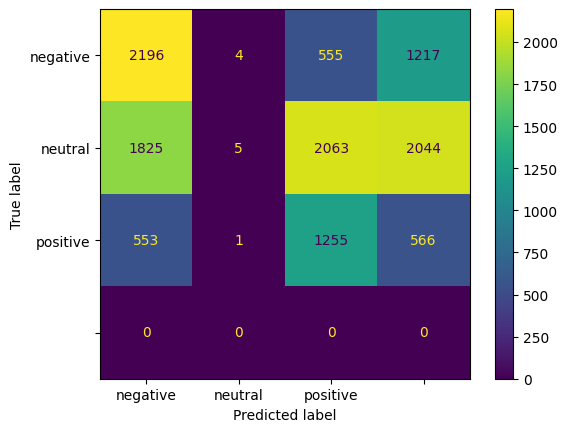

In [ ]:
initial_f1 = eval(model, dataset["test"], tokenizer)
print(f"Initial Macro F1: {initial_f1:.2f}")

# LoRA: [Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685)

В традиционном fine-tuning больших языковых моделей требуется обновление огромного числа параметров, что приводит к высоким вычислительным затратам и потреблению памяти. Метод LoRA решает эту проблему, вводя низкоранговые обновления весов.

Пусть $(W_0 \in \mathbb{R}^{d \times k})$ - исходная матрица весов модели. При адаптации модели предполагается, что обновление весов можно аппроксимировать матрицей низкого ранга:
$$
\Delta W = BA, \quad B \in \mathbb{R}^{d \times r}, \quad A \in \mathbb{R}^{r \times k},
$$
где $r \ll \min(d, k)$.

Обновлённая матрица весов записывается как:
$$
W = W_0 + \Delta W = W_0 + B A.
$$

Основная идея заключается в том, чтобы заморозить исходные параметры $W_0$ и обучать только матрицы $A$ и $B$. Это существенно уменьшает число обучаемых параметров, так как их суммарное количество равно $r \times (d+k)$ по сравнению с $d \times k$ для полной матрицы $W$.

Матрицу $A$ рекомендуется инициализировать нормальным распределением $N(0, \frac{1}{\sqrt{r}})$, а матрицу $B$ нулями. Также не забывайте про скейлинг $\Delta Wx$ на $\frac{\alpha}{r}$, где $\alpha$ гипер-параметр. Во время обучения его можно зафиксировать $\alpha=16$.

## Адаптиация модели с LoRA слоями [4 балла]

В этом задачнии вам потребуется:
1. Дописать класс `LoRALayer` который заменит слои модели
2. Дописать функцию рекурсивного обхода модели, чтобы применить к ней `LinearWithLoRA`
3. Обновить модель

In [ ]:
class LoRALayer(nn.Module):
    """Implements a low-rank adaptation layer for a linear transformation.
    This layer introduces a trainable low-rank update to the input tensor.

    The forward computation is defined as:
        output = alpha * (x @ A @ B)

    Attributes:
        B (nn.Parameter): A weight matrix of shape (in_dim, rank), initialized to zeros.
        A (nn.Parameter): A weight matrix of shape (rank, out_dim), initialized with random values
                            scaled by 1/sqrt(rank).
        alpha (float): A scaling factor for the low-rank update.
    """

    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        # todo()
        a_tsr = torch.empty(rank, in_dim)
        torch.nn.init.normal_(a_tsr, mean=0, std=1 / np.sqrt(rank))
        b_tsr = torch.empty(out_dim, rank)
        torch.nn.init.zeros_(b_tsr)
        self.A = nn.Parameter(a_tsr)
        self.B = nn.Parameter(b_tsr)
        self.scale = alpha / rank
    def forward(self, x):
        # todo()
        return self.scale * torch.nn.functional.linear(x, self.B @ self.A, bias=None)


class LinearWithLoRA(nn.Module):
    """Combines a standard linear layer with a LoRA (Low-Rank Adaptation) layer.
    The forward pass returns the sum of the output of the linear layer and the low-rank update.

    Attributes:
        linear (nn.Module): The original linear layer.
        lora (LoRALayer): The low-rank adaptation layer configured with matching input and output dimensions.
    """

    def __init__(self, linear, rank, alpha):
        super().__init__()
        # todo()
        self.linear = linear
        self.lora = LoRALayer(in_dim=linear.in_features, out_dim=linear.out_features, rank=rank, alpha=alpha)

    def forward(self, x):
        # todo()
        return self.linear(x) + self.lora(x)

In [ ]:
def apply_peft_to_module(model, adapter_class, r, alpha, target_submodules):
    """Recursively applies a parameter-efficient fine-tuning (PEFT) adapter to target submodules within a model.

    This function traverses the model's children recursively. For each submodule whose name contains any
    of the strings specified in 'target_submodules', it wraps the submodule using the provided adapter class.

    Args:
        model (nn.Module): The neural network model to modify.
        adapter_class (nn.Module): The adapter class (e.g., LoRALayer or LinearWithLoRA) used to wrap target submodules.
        r (int): The rank parameter for the adapter.
        alpha (float): The scaling factor for the low-rank update.
        target_submodules (list of str): A list of substrings to match against submodule names for applying the adapter.

    Returns:
        None. The function updates the model in-place.
    """
    for name, module in model.named_children():
        for target in target_submodules:
            if target in name and isinstance(module, nn.Linear):
                setattr(model, name, adapter_class(module, r, alpha))
        apply_peft_to_module(module, adapter_class, r, alpha, target_submodules)
    # todo()

### Применим наш LoRA adapter к нашей модели

Обычно для дешевого обучения достаточно применить LoRA к слоям для ключей `k_proj` и значений `v_proj`. Однако, если вы уверены в своих действиях, то не воспрещается обучать и другие слои с помощью LoRA :)

In [ ]:
# Примените peft к модели
apply_peft_to_module(model, LinearWithLoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])

In [ ]:
# Заморозьте не нужные слои


def freeze_layers(model, patterns):
    for name, param in model.named_parameters():
        # todo()
        param.requires_grad = any(p in name for p in patterns)

    total_params, trainable_params = 0, 0
    for name, param in model.named_parameters():
        print(f"{name}: {param.requires_grad}")
        total_params += np.prod(param.shape)
        if param.requires_grad:
            trainable_params += np.prod(param.shape)
    print(f"Train {trainable_params}/{total_params} ({trainable_params / total_params * 100:.2f}%) parameters")

    return model


model = freeze_layers(model, ["lora"])

model.embed_tokens.weight: False
model.layers.0.self_attn.q_proj.weight: False
model.layers.0.self_attn.k_proj.linear.weight: False
model.layers.0.self_attn.k_proj.lora.A: True
model.layers.0.self_attn.k_proj.lora.B: True
model.layers.0.self_attn.v_proj.linear.weight: False
model.layers.0.self_attn.v_proj.lora.A: True
model.layers.0.self_attn.v_proj.lora.B: True
model.layers.0.self_attn.o_proj.weight: False
model.layers.0.mlp.gate_proj.weight: False
model.layers.0.mlp.up_proj.weight: False
model.layers.0.mlp.down_proj.weight: False
model.layers.0.input_layernorm.weight: False
model.layers.0.post_attention_layernorm.weight: False
model.layers.1.self_attn.q_proj.weight: False
model.layers.1.self_attn.k_proj.linear.weight: False
model.layers.1.self_attn.k_proj.lora.A: True
model.layers.1.self_attn.k_proj.lora.B: True
model.layers.1.self_attn.v_proj.linear.weight: False
model.layers.1.self_attn.v_proj.lora.A: True
model.layers.1.self_attn.v_proj.lora.B: True
model.layers.1.self_attn.o_proj

## Обучение [2 балла]

*Напутствие:*
Пришло время приступить к обучению модели. После реализации train loop вы заслужите перерыв на 30+ минут – отличный повод с гордостью заявить, что вы заняты обучением модели. Однако длительность отдыха остаётся на ваше усмотрение. Мы рекомендуем ограничиться 2–3 эпохами файнтюна, чтобы избежать излишних вычислительных затрат и переобучения модели.

Обратите внимание, что вам предстоит реализовать классический train loop на PyTorch. Здесь у вас достаточно свободы для выбора гиперпараметров (`batch_size`, `lr`, `num_epochs`). Вы можете использовать дополнительные гиперпараметры на свое усмотрение, например, для оптимизатора.

In [ ]:
def pad_collate_fn(batch: list[dict[str, torch.Tensor]], pad_token_id: int) -> dict[str, torch.Tensor]:
    """Collates and pads a batch of tokenized examples for model input.

    This function takes a batch of examples where each example is a dictionary containing
    token IDs for the prompt, the chosen response, and the rejected response. For each field,
    it extracts the list of token IDs, creates a corresponding attention mask (with ones for each token),
    and then pads the sequences using a `pad` function. The prompt sequences and their attention masks
    are padded on the left, while the chosen and rejected sequences are padded on the right (default).

    Args:
        batch (list[dict[str, torch.Tensor]]): A list of dictionaries with input_ids keys
        pad_token_id (int): Padding value for token IDs.

    Returns:
        dict[str, torch.Tensor]: A dictionary containing the following keys with padded tensors:
            - "prompt_input_ids": Padded token IDs for the prompt (padded on the left).
            - "prompt_attn_mask": Padded attention mask for the prompt (padded on the left, with 1s for actual tokens).
            - "chosen_input_ids": Padded token IDs for the chosen response.
            - "chosen_attn_mask": Padded attention mask for the chosen response.
            - "rejected_input_ids": Padded token IDs for the rejected response.
            - "rejected_attn_mask": Padded attention mask for the rejected response.
    """
    # ========== TODO ==========
    #      Ваш код здесь       =
    # ==========================
    # todo()
    prompt_mode = 'left'
    full_prompt_ids = [batch[i]['full_input_ids'] for i in range(len(batch))]
    full_prompt_attn = [torch.full_like(full_prompt_ids[i], 1) for i in range(len(full_prompt_ids))]
    full_prompt_ids = pad(full_prompt_ids, pad_token_id, prompt_mode)
    full_prompt_attn = pad(full_prompt_attn, 0, prompt_mode)

    full_prompt_ids = torch.cat((full_prompt_ids, torch.full((len(batch), 2), pad_token_id)), dim=1)
    full_prompt_attn = torch.cat((full_prompt_attn, torch.full((len(batch), 2), 1)), dim=1)
    labels = full_prompt_ids.clone()
    prompt_ids = [batch[i]['input_ids'] for i in range(len(batch))]
    for i in range(len(prompt_ids)):
        i_to_zero = full_prompt_attn.shape[1] - full_prompt_attn[i].count_nonzero() + len(prompt_ids[i])
        labels[i, :i_to_zero] = -100
    result = {
        'input_ids': full_prompt_ids,
        'attention_mask': full_prompt_attn,
        'labels': labels
    }

    return result

In [ ]:
dataloader = DataLoader(
    dataset.with_format("torch")["train"],
    batch_size=2,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)
next(iter(dataloader))

{'input_ids': tensor([[32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
          32000,     1, 32001,  1587,    13,  2472,  1575,  2188, 28742, 28713,
           2245, 28723, 26307,  9688,  9880, 26071,  1707,   297,   272,  9688,
           9880, 26071,  1407,   304,   708,   680,  1159,   304,  1024, 28723,
           1770, 21435,  2065, 28725,   708,  4870,   633,  4715, 28723, 26307,
            541,   347, 28747,  5278, 28725, 14214,   442,  7087, 28723, 32000,
          28705,    13, 32001,  2188,    13, 28737,   541, 28756, 28718, 28750,
          28734, 28740, 28774, 28707,  2444,   298,  1236,   456, 12165,  2737,
          13268,   684,  9262,  2125, 13915,  3539, 28716,   521,   295,  8884,
           4893,  4382, 32000, 28705,    13, 32001, 13892,    13,  1065,  2468,
          32000, 28705,    13, 32000, 32000, 32000],
         [    1, 32001,  1587,    13,  2472,  1575,  2188, 28742, 28713,  2245,
          28723, 26307,  9688,  9880, 26071,  1707,   

In [ ]:
def train_model(model, optimizer, train_dataloader, val_dataset, num_epochs):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for step, batch in enumerate(tqdm(train_dataloader)):
            batch = {k: (v.to(model.device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            if step % 50 == 0 and step > 0:
                avg_loss = running_loss / 50
                print(f"Epoch {epoch + 1}, Step {step} | Avg Loss: {avg_loss:.4f}")
                running_loss = 0.0

        val_f1 = eval(model, val_dataset, tokenizer, show_conf_m=False)
        print(f"Epoch {epoch + 1} | Validation F1: {val_f1}")
    return model

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 5e-4
NUM_EPOCHS = 1

train_dataloader = DataLoader(
    dataset.with_format("torch")["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)

optimizer = torch.optim.AdamW([p for n, p in model.named_parameters() if "lora" in n], lr=LEARNING_RATE)

In [ ]:
model = train_model(model.to(DEVICE), optimizer, train_dataloader, dataset["validation"], NUM_EPOCHS)

  0%|          | 0/2851 [00:00<?, ?it/s]

Epoch 1, Step 50 | Avg Loss: 0.2404
Epoch 1, Step 100 | Avg Loss: 0.1148
Epoch 1, Step 150 | Avg Loss: 0.1001
Epoch 1, Step 200 | Avg Loss: 0.0991
Epoch 1, Step 250 | Avg Loss: 0.1036
Epoch 1, Step 300 | Avg Loss: 0.0927
Epoch 1, Step 350 | Avg Loss: 0.0940
Epoch 1, Step 400 | Avg Loss: 0.0920
Epoch 1, Step 450 | Avg Loss: 0.0881
Epoch 1, Step 500 | Avg Loss: 0.0900
Epoch 1, Step 550 | Avg Loss: 0.0801
Epoch 1, Step 600 | Avg Loss: 0.0898
Epoch 1, Step 650 | Avg Loss: 0.0834
Epoch 1, Step 700 | Avg Loss: 0.0863
Epoch 1, Step 750 | Avg Loss: 0.0919
Epoch 1, Step 800 | Avg Loss: 0.0832
Epoch 1, Step 850 | Avg Loss: 0.0832
Epoch 1, Step 900 | Avg Loss: 0.0921
Epoch 1, Step 950 | Avg Loss: 0.0844
Epoch 1, Step 1000 | Avg Loss: 0.0856
Epoch 1, Step 1050 | Avg Loss: 0.0855
Epoch 1, Step 1100 | Avg Loss: 0.0845
Epoch 1, Step 1150 | Avg Loss: 0.0843
Epoch 1, Step 1200 | Avg Loss: 0.0880
Epoch 1, Step 1250 | Avg Loss: 0.0850
Epoch 1, Step 1300 | Avg Loss: 0.0881
Epoch 1, Step 1350 | Avg Loss: 0

Batching examples: 100%|██████████| 2000/2000 [00:00<00:00, 5947.56 examples/s]


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 | Validation F1: 0.5263879733242898


In [ ]:
for i in range(5):
    input_ids = torch.tensor([dataset["train"][i]["input_ids"]], device=DEVICE)
    generated_text = generate_class(model, tokenizer, input_ids)
    print(dataset["train"][i]["text"])
    print(dataset["train"][i]["str_label"])
    print(generated_text)
    print("=" * 10)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
positive
positive 

"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
neutral
neutral 

Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
neutral
negative 

Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
neutral
neutral 

@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
positive
neutral 



## Оценим результаты

Теперь увидим, как повлиял наш файнтюнинг

  0%|          | 0/123 [00:00<?, ?it/s]

After LoRA Macro F1: 0.52


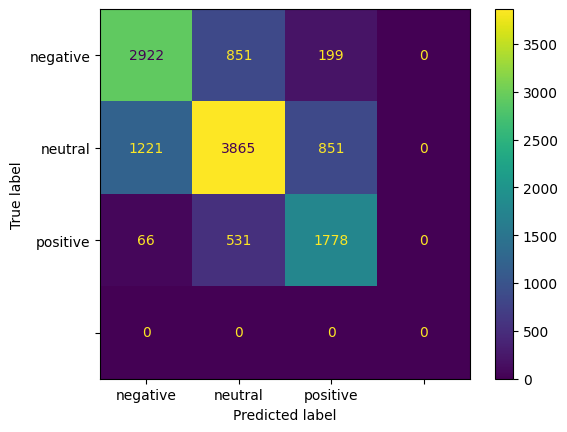

In [ ]:
after_lora_f1 = eval(model, dataset["test"], tokenizer)
print(f"After LoRA Macro F1: {after_lora_f1:.2f}")

In [ ]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-lora")
tokenizer.push_to_hub(f"{REPO_NAME}-lora")

model.safetensors: 100%|██████████| 1.20G/1.20G [00:35<00:00, 33.5MB/s]  
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/gsemenyak/llm-course-hw3-lora/commit/451db85bd6f34065a505cc5be39770ddbde4a231', commit_message='Upload tokenizer', commit_description='', oid='451db85bd6f34065a505cc5be39770ddbde4a231', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gsemenyak/llm-course-hw3-lora', endpoint='https://huggingface.co', repo_type='model', repo_id='gsemenyak/llm-course-hw3-lora'), pr_revision=None, pr_num=None)

In [ ]:
# Очистим память
gc.collect()
torch.cuda.empty_cache()

## DoRA: [Weight-Decomposed Low-Rank Adaptation](https://arxiv.org/abs/2402.09353)

В отличие от метода LoRA, где обновление весов модели представлено в виде низкорангового произведения, метод DoRA вводит дополнительную степень гибкости за счёт применения диагональной матрицы для весового масштабирования.

Пусть $W_0 \in \mathbb{R}^{d \times k}$ - исходная матрица весов. В DoRA обновление весов определяется следующим образом:
$$
W = m \frac{W_0 + BA}{\|W_0 + BA \|}
$$

Где $BA$ соответствует использованию LoRA, а $m \in \mathbb{R}^{k}$ обучаемый вектор.

## Обучение модели с помощью DoRA [8 баллов]

В этом задании вам потребуется:
1. Написать с нуля класс `LinearWithDoRA` который использует написанный ранее `LoRALayer` класс
2. Применить его к модели
3. Обучить модель

In [ ]:
class LinearWithDoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)
        self.scale = nn.Parameter(torch.linalg.norm(linear.weight, dim=0, keepdim=True))

    def forward(self, x):

        W = self.linear.weight + (self.lora.B @ self.lora.A) * self.lora.scale
        W_norm = torch.linalg.norm(W, dim=0, keepdim=True)
        W_scaled = self.scale * (W / W_norm)
        return torch.nn.functional.linear(x, W_scaled, self.linear.bias)

Сбрасываем модель и применяем наш DoRA адаптер

In [ ]:
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

apply_peft_to_module(model, LinearWithDoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])

model = freeze_layers(model, ["lora"])

model.embed_tokens.weight: False
model.layers.0.self_attn.q_proj.weight: False
model.layers.0.self_attn.k_proj.scale: False
model.layers.0.self_attn.k_proj.linear.weight: False
model.layers.0.self_attn.k_proj.lora.A: True
model.layers.0.self_attn.k_proj.lora.B: True
model.layers.0.self_attn.v_proj.scale: False
model.layers.0.self_attn.v_proj.linear.weight: False
model.layers.0.self_attn.v_proj.lora.A: True
model.layers.0.self_attn.v_proj.lora.B: True
model.layers.0.self_attn.o_proj.weight: False
model.layers.0.mlp.gate_proj.weight: False
model.layers.0.mlp.up_proj.weight: False
model.layers.0.mlp.down_proj.weight: False
model.layers.0.input_layernorm.weight: False
model.layers.0.post_attention_layernorm.weight: False
model.layers.1.self_attn.q_proj.weight: False
model.layers.1.self_attn.k_proj.scale: False
model.layers.1.self_attn.k_proj.linear.weight: False
model.layers.1.self_attn.k_proj.lora.A: True
model.layers.1.self_attn.k_proj.lora.B: True
model.layers.1.self_attn.v_proj.scale: 

### Обучение

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 5e-4
NUM_EPOCHS = 2

train_dataloader = DataLoader(
    dataset.with_format("torch")["train"].take(10_000),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)

optimizer = torch.optim.AdamW(
    [p for n, p in model.named_parameters() if "lora" in n], lr=LEARNING_RATE, weight_decay=0.01
)

In [ ]:
model = train_model(model.to(DEVICE), optimizer, train_dataloader, dataset["validation"], NUM_EPOCHS)

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1, Step 50 | Avg Loss: 0.2507
Epoch 1, Step 100 | Avg Loss: 0.1102
Epoch 1, Step 150 | Avg Loss: 0.1054
Epoch 1, Step 200 | Avg Loss: 0.0985
Epoch 1, Step 250 | Avg Loss: 0.1010
Epoch 1, Step 300 | Avg Loss: 0.0929
Epoch 1, Step 350 | Avg Loss: 0.0962
Epoch 1, Step 400 | Avg Loss: 0.0921
Epoch 1, Step 450 | Avg Loss: 0.0911
Epoch 1, Step 500 | Avg Loss: 0.0886
Epoch 1, Step 550 | Avg Loss: 0.0931
Epoch 1, Step 600 | Avg Loss: 0.0916


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 | Validation F1: 0.48285889382419556


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2, Step 50 | Avg Loss: 0.0724
Epoch 2, Step 100 | Avg Loss: 0.0819
Epoch 2, Step 150 | Avg Loss: 0.0699
Epoch 2, Step 200 | Avg Loss: 0.0737
Epoch 2, Step 250 | Avg Loss: 0.0773
Epoch 2, Step 300 | Avg Loss: 0.0792
Epoch 2, Step 350 | Avg Loss: 0.0797
Epoch 2, Step 400 | Avg Loss: 0.0762
Epoch 2, Step 450 | Avg Loss: 0.0769
Epoch 2, Step 500 | Avg Loss: 0.0775
Epoch 2, Step 550 | Avg Loss: 0.0764
Epoch 2, Step 600 | Avg Loss: 0.0799


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 | Validation F1: 0.514690961147037


In [ ]:
for i in range(5):
    input_ids = torch.tensor([dataset["train"][i]["input_ids"]], device=DEVICE)
    generated_text = generate_class(model, tokenizer, input_ids)
    print(dataset["train"][i]["text"])
    print(dataset["train"][i]["str_label"])
    print(generated_text)
    print("=" * 10)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
positive
positive 

"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
neutral
neutral 

Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
neutral
positive 

Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
neutral
neutral 

@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
positive
neutral 



  0%|          | 0/123 [00:00<?, ?it/s]

After DoRA Macro F1: 0.51


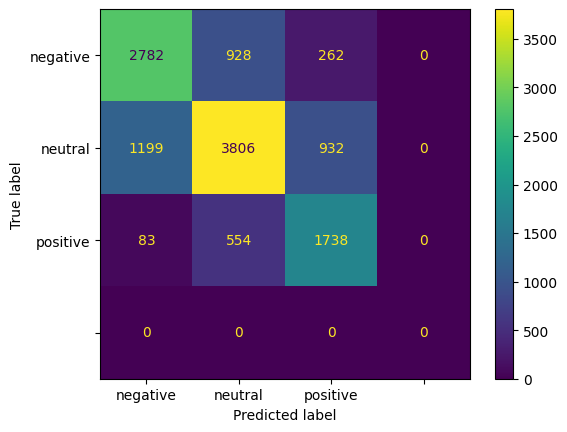

In [ ]:
after_dora_f1 = eval(model, dataset["test"], tokenizer)
print(f"After DoRA Macro F1: {after_dora_f1:.2f}")

Для качественного обучения доры в этой задаче нужно постараться.
Будем считать, что если качество > 0.5, то задание с учетом правильности кода решено верно

In [ ]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-dora")
tokenizer.push_to_hub(f"{REPO_NAME}-dora")

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/gsemenyak/llm-course-hw3-dora/commit/1ea5ef05fa01da9445dc3b83610a8b31acdf9039', commit_message='Upload tokenizer', commit_description='', oid='1ea5ef05fa01da9445dc3b83610a8b31acdf9039', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gsemenyak/llm-course-hw3-dora', endpoint='https://huggingface.co', repo_type='model', repo_id='gsemenyak/llm-course-hw3-dora'), pr_revision=None, pr_num=None)

In [ ]:
# Очистим память
gc.collect()
torch.cuda.empty_cache()

## Frameworks way [4 балла]

### QLoRA: [Efficient Finetuning of Quantized LLMs](https://arxiv.org/pdf/2305.14314)

Метод QLoRA направлен на эффективное дообучение предварительно обученных больших языковых моделей с использованием квантования весов. Основная идея заключается в том, что во время обратного распространения ошибки модель квантует исходные веса с точностью до 4 бит, что позволяет значительно сократить использование GPU памяти. Для обработки пиков памяти при этом применяются страничные оптимизаторы.

В результате, применение QLoRA часто приводит к экономии GPU памяти примерно на $\dfrac{1}{3}$, однако время обучения при этом может увеличиться почти на $\dfrac{1}{4}$ по сравнению с традиционными методами дообучения.

Такой компромисс между экономией памяти и увеличением времени обучения делает QLoRA привлекательным решением в сценариях, где ресурсы ограничены, а эффективность использования памяти критически важна.

Теперь с таким прекрасным инструментом как QLoRA можем рассмотреть более тяжелую модель аж 1.1B :)

Используйте документацию библиотек [HuggingFace Transformers](https://huggingface.co/docs/transformers/index) и [PEFT](https://huggingface.co/docs/peft/index).

1. Конфигурация квантизации (`BitsAndBytesConfig`): Подберите тип 4-битной квантизации (`bnb_4bit_quant_type`) и размерность подсчёта (`bnb_4bit_compute_dtype`)

2. Настройка LoRA-адаптеров (`LoraConfig`):
    - Подберите и обоснуйте значения следующих гиперпараметров:
        - `lora_alpha`
        - `lora_dropout`
        - `r`
    - Выберите модули модели, к которым следует применять LoRA-адаптеры (`target_modules`).

3. Настройка параметров обучения (`TrainingArguments`, `SFTTrainer`):
Используя документацию и подберите параметры:
    - `learning_rate`
    - `num_train_epochs`
    - `gradient_accumulation_steps`
    - `lr_scheduler_type`
    - `per_device_train_batch_size`
    - другие параметры по необходимости

4. Проведение обучения и анализ результатов:
    - Запустите обучение модели.
    - Оцените модель до и после обучения.
    - сохраните модель


In [ ]:
LARGE_MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Заведем конфиг для квантизации
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Инициализация квантованной модели
model = AutoModelForCausalLM.from_pretrained(LARGE_MODEL_NAME, quantization_config=bnb_config)
model = model.to(DEVICE)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(LARGE_MODEL_NAME)
tokenizer.pad_token = "<PAD>"
tokenizer.padding_side = "left"

In [ ]:
for split, data in dataset.items():
    dataset[split] = data.map(process_example, fn_kwargs={"tokenizer": tokenizer})
    dataset[split] = data.map(tokenization, batched=True, fn_kwargs={"tokenizer": tokenizer})

for i in range(2):
    for k, v in dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label: 2
str_label: positive
prompt: <|im_start|>system
Classify user's text. Answer ONLY ONE word in the ONLY ONE line and no more before and after. No repetitions, no additional new lines. Answer can be: positive, neutral or negative.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant

full_prompt: <|im_start|>system
Classify user's text. Answer ONLY ONE word in the ONLY ONE line and no more before and after. No repetitions, no additional new lines. Answer can be: positive, neutral or negative.<|im_end|>
<|im_start|>user
"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"<|im_end|>
<|im_start|>assistant
positive<|im_end|>
<|im_end|>
input_ids: [1, 529, 29989, 326, 299

Batching examples: 100%|██████████| 12284/12284 [00:02<00:00, 4680.00 examples/s]


  0%|          | 0/123 [00:00<?, ?it/s]

Initial F1 large model: 0.04


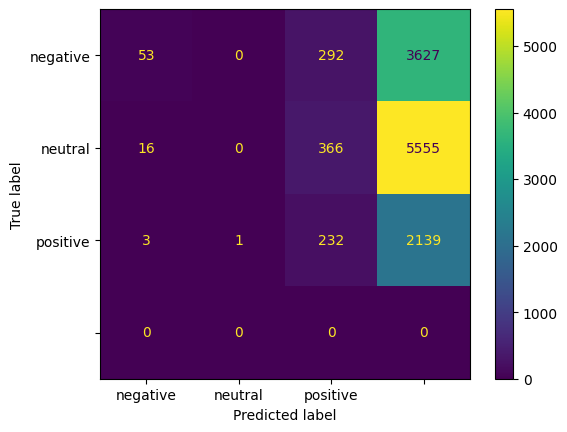

In [ ]:
initial_f1_large_model = eval(model, dataset["test"], tokenizer)
print(f"Initial F1 large model: {initial_f1_large_model:.2f}")

### Обучим QLoRA

In [ ]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["k_proj", "v_proj"],
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)
model.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=256, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=256, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lo

`SFTTrainer` supports conversational format:
```
{"messages": [{"role": "system", "content": "You are helpful"}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "..."}]}
{"messages": [{"role": "system", "content": "You are helpful"}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "..."}]}
{"messages": [{"role": "system", "content": "You are helpful"}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "..."}]}
```

In [ ]:
def convert_instruction_format(example, system_prompt=SYSTEM_PROMPT):
    conversation = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Text: {example['text']}"},
        {"role": "assistant", "content": example["str_label"]},
    ]
    return {"messages": conversation}


sft_dataset = dataset.copy()
for split, data in dataset.items():
    sft_dataset[split] = data.map(
        convert_instruction_format,
        remove_columns=["text", "label", "str_label", "prompt", "full_prompt", "input_ids", "full_input_ids"],
    )

for i in range(2):
    for k, v in sft_dataset["train"][i].items():
        print(f"{k}: {v}")
    print("=" * 10)

messages: [{'content': "Classify user's text. Answer ONLY ONE word in the ONLY ONE line and no more before and after. No repetitions, no additional new lines. Answer can be: positive, neutral or negative.", 'role': 'system'}, {'content': 'Text: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'role': 'user'}, {'content': 'positive', 'role': 'assistant'}]
messages: [{'content': "Classify user's text. Answer ONLY ONE word in the ONLY ONE line and no more before and after. No repetitions, no additional new lines. Answer can be: positive, neutral or negative.", 'role': 'system'}, {'content': 'Text: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"', 'role': 'user'}, {'content': 'neutral', 'role': 'assistant'}]


In [ ]:
training_arguments = TrainingArguments(
    output_dir="./output/",
    learning_rate=5e-4,
    num_train_epochs=2,
    gradient_accumulation_steps=1,
    lr_scheduler_type="linear",
    warmup_steps=300,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    report_to="none",
    logging_steps=25,
    save_strategy="no",
)

trainer = SFTTrainer(
    model=model,
    train_dataset=sft_dataset["train"],
    args=training_arguments,
    peft_config=peft_config,
    processing_class=tokenizer,
)
trainer.train()

Truncating train dataset: 100%|██████████| 45615/45615 [00:01<00:00, 32035.31 examples/s] 
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
  1%|          | 25/2852 [00:09<17:06,  2.76it/s]

{'loss': 2.974, 'grad_norm': 1.8477866649627686, 'learning_rate': 4e-05, 'num_tokens': 89752.0, 'mean_token_accuracy': 0.47908958077430724, 'epoch': 0.02}


  2%|▏         | 50/2852 [00:18<17:21,  2.69it/s]

{'loss': 2.5892, 'grad_norm': 2.264805316925049, 'learning_rate': 8.166666666666667e-05, 'num_tokens': 179344.0, 'mean_token_accuracy': 0.5116323029994965, 'epoch': 0.04}


  3%|▎         | 75/2852 [00:26<16:03,  2.88it/s]

{'loss': 1.5649, 'grad_norm': 0.9651185870170593, 'learning_rate': 0.00012333333333333334, 'num_tokens': 269035.0, 'mean_token_accuracy': 0.6937165069580078, 'epoch': 0.05}


  4%|▎         | 100/2852 [00:35<16:14,  2.82it/s]

{'loss': 1.0928, 'grad_norm': 0.5137462615966797, 'learning_rate': 0.000165, 'num_tokens': 358658.0, 'mean_token_accuracy': 0.8072382855415344, 'epoch': 0.07}


  4%|▍         | 125/2852 [00:44<16:14,  2.80it/s]

{'loss': 1.009, 'grad_norm': 0.45577165484428406, 'learning_rate': 0.00020666666666666666, 'num_tokens': 447939.0, 'mean_token_accuracy': 0.8129424285888672, 'epoch': 0.09}


  5%|▌         | 150/2852 [00:53<15:32,  2.90it/s]

{'loss': 0.996, 'grad_norm': 0.4864497780799866, 'learning_rate': 0.0002483333333333333, 'num_tokens': 537810.0, 'mean_token_accuracy': 0.8137461471557618, 'epoch': 0.11}


  6%|▌         | 175/2852 [01:02<15:40,  2.85it/s]

{'loss': 1.0065, 'grad_norm': 0.4744096100330353, 'learning_rate': 0.00029, 'num_tokens': 627797.0, 'mean_token_accuracy': 0.8125205278396607, 'epoch': 0.12}


  7%|▋         | 200/2852 [01:11<15:12,  2.91it/s]

{'loss': 0.9692, 'grad_norm': 0.5055748820304871, 'learning_rate': 0.0003316666666666667, 'num_tokens': 716928.0, 'mean_token_accuracy': 0.819195396900177, 'epoch': 0.14}


  8%|▊         | 225/2852 [01:19<15:17,  2.86it/s]

{'loss': 0.9765, 'grad_norm': 0.4384869337081909, 'learning_rate': 0.0003733333333333334, 'num_tokens': 806393.0, 'mean_token_accuracy': 0.8171687889099121, 'epoch': 0.16}


  9%|▉         | 250/2852 [01:28<15:33,  2.79it/s]

{'loss': 0.9721, 'grad_norm': 0.4357649087905884, 'learning_rate': 0.000415, 'num_tokens': 896191.0, 'mean_token_accuracy': 0.8171828365325928, 'epoch': 0.18}


 10%|▉         | 275/2852 [01:38<18:44,  2.29it/s]

{'loss': 0.9543, 'grad_norm': 0.4135551154613495, 'learning_rate': 0.0004566666666666667, 'num_tokens': 985505.0, 'mean_token_accuracy': 0.8198105692863464, 'epoch': 0.19}


 11%|█         | 300/2852 [01:46<14:28,  2.94it/s]

{'loss': 0.9532, 'grad_norm': 0.44974491000175476, 'learning_rate': 0.0004983333333333334, 'num_tokens': 1074996.0, 'mean_token_accuracy': 0.8203847885131836, 'epoch': 0.21}


 11%|█▏        | 325/2852 [01:55<14:46,  2.85it/s]

{'loss': 0.9417, 'grad_norm': 0.3635156750679016, 'learning_rate': 0.0004952978056426332, 'num_tokens': 1164036.0, 'mean_token_accuracy': 0.8208274388313294, 'epoch': 0.23}


 12%|█▏        | 350/2852 [02:04<16:52,  2.47it/s]

{'loss': 0.9457, 'grad_norm': 0.4083157479763031, 'learning_rate': 0.0004903996865203762, 'num_tokens': 1253585.0, 'mean_token_accuracy': 0.8201586174964904, 'epoch': 0.25}


 13%|█▎        | 375/2852 [02:13<13:53,  2.97it/s]

{'loss': 0.9434, 'grad_norm': 0.3650020956993103, 'learning_rate': 0.0004855015673981191, 'num_tokens': 1343213.0, 'mean_token_accuracy': 0.8216734051704406, 'epoch': 0.26}


 14%|█▍        | 400/2852 [02:22<14:27,  2.83it/s]

{'loss': 0.9448, 'grad_norm': 0.471227765083313, 'learning_rate': 0.00048060344827586203, 'num_tokens': 1433228.0, 'mean_token_accuracy': 0.8205369019508362, 'epoch': 0.28}


 15%|█▍        | 425/2852 [02:31<14:22,  2.81it/s]

{'loss': 0.9587, 'grad_norm': 0.3315121829509735, 'learning_rate': 0.000475705329153605, 'num_tokens': 1523010.0, 'mean_token_accuracy': 0.8192444515228271, 'epoch': 0.3}


 16%|█▌        | 450/2852 [02:39<13:43,  2.92it/s]

{'loss': 0.9393, 'grad_norm': 0.3555935323238373, 'learning_rate': 0.00047080721003134795, 'num_tokens': 1612034.0, 'mean_token_accuracy': 0.8223781633377075, 'epoch': 0.32}


 17%|█▋        | 475/2852 [02:48<14:04,  2.81it/s]

{'loss': 0.9567, 'grad_norm': 0.3587682843208313, 'learning_rate': 0.0004659090909090909, 'num_tokens': 1702029.0, 'mean_token_accuracy': 0.8197088527679444, 'epoch': 0.33}


 18%|█▊        | 500/2852 [02:57<13:38,  2.87it/s]

{'loss': 0.9331, 'grad_norm': 0.4281797409057617, 'learning_rate': 0.00046101097178683387, 'num_tokens': 1791069.0, 'mean_token_accuracy': 0.8224643874168396, 'epoch': 0.35}


 18%|█▊        | 525/2852 [03:06<13:21,  2.90it/s]

{'loss': 0.9539, 'grad_norm': 0.36807188391685486, 'learning_rate': 0.0004561128526645768, 'num_tokens': 1880982.0, 'mean_token_accuracy': 0.8199466443061829, 'epoch': 0.37}


 19%|█▉        | 550/2852 [03:15<14:30,  2.65it/s]

{'loss': 0.9252, 'grad_norm': 0.3313189446926117, 'learning_rate': 0.00045121473354231973, 'num_tokens': 1970413.0, 'mean_token_accuracy': 0.8236730861663818, 'epoch': 0.39}


 20%|██        | 575/2852 [03:24<13:17,  2.85it/s]

{'loss': 0.9507, 'grad_norm': 0.3113540709018707, 'learning_rate': 0.0004463166144200627, 'num_tokens': 2060224.0, 'mean_token_accuracy': 0.8213409352302551, 'epoch': 0.4}


 21%|██        | 600/2852 [03:32<13:17,  2.82it/s]

{'loss': 0.9371, 'grad_norm': 0.34180352091789246, 'learning_rate': 0.00044141849529780565, 'num_tokens': 2149456.0, 'mean_token_accuracy': 0.8224249315261841, 'epoch': 0.42}


 22%|██▏       | 625/2852 [03:41<13:33,  2.74it/s]

{'loss': 0.9331, 'grad_norm': 0.356898695230484, 'learning_rate': 0.0004365203761755486, 'num_tokens': 2239105.0, 'mean_token_accuracy': 0.8218521428108215, 'epoch': 0.44}


 23%|██▎       | 650/2852 [03:50<13:08,  2.79it/s]

{'loss': 0.9386, 'grad_norm': 0.3282569646835327, 'learning_rate': 0.00043162225705329157, 'num_tokens': 2328811.0, 'mean_token_accuracy': 0.822303102016449, 'epoch': 0.46}


 24%|██▎       | 675/2852 [03:59<12:53,  2.81it/s]

{'loss': 0.9642, 'grad_norm': 0.38654467463493347, 'learning_rate': 0.0004267241379310345, 'num_tokens': 2418896.0, 'mean_token_accuracy': 0.8173418927192688, 'epoch': 0.47}


 25%|██▍       | 700/2852 [04:08<12:32,  2.86it/s]

{'loss': 0.9404, 'grad_norm': 0.30455273389816284, 'learning_rate': 0.00042182601880877743, 'num_tokens': 2508683.0, 'mean_token_accuracy': 0.8219688963890076, 'epoch': 0.49}


 25%|██▌       | 725/2852 [04:16<12:29,  2.84it/s]

{'loss': 0.9141, 'grad_norm': 0.3101658821105957, 'learning_rate': 0.0004169278996865204, 'num_tokens': 2597752.0, 'mean_token_accuracy': 0.8257335162162781, 'epoch': 0.51}


 26%|██▋       | 750/2852 [04:26<12:34,  2.78it/s]

{'loss': 0.9419, 'grad_norm': 0.32547643780708313, 'learning_rate': 0.0004120297805642633, 'num_tokens': 2687063.0, 'mean_token_accuracy': 0.8220529246330261, 'epoch': 0.53}


 27%|██▋       | 775/2852 [04:34<12:03,  2.87it/s]

{'loss': 0.9321, 'grad_norm': 0.28921571373939514, 'learning_rate': 0.00040713166144200623, 'num_tokens': 2776338.0, 'mean_token_accuracy': 0.8244158554077149, 'epoch': 0.54}


 28%|██▊       | 800/2852 [04:43<12:10,  2.81it/s]

{'loss': 0.9359, 'grad_norm': 0.331671804189682, 'learning_rate': 0.0004022335423197492, 'num_tokens': 2865965.0, 'mean_token_accuracy': 0.8219350361824036, 'epoch': 0.56}


 29%|██▉       | 825/2852 [04:52<11:42,  2.88it/s]

{'loss': 0.94, 'grad_norm': 0.30669066309928894, 'learning_rate': 0.00039733542319749215, 'num_tokens': 2955782.0, 'mean_token_accuracy': 0.8217442393302917, 'epoch': 0.58}


 30%|██▉       | 850/2852 [05:01<11:30,  2.90it/s]

{'loss': 0.9404, 'grad_norm': 0.34754446148872375, 'learning_rate': 0.0003924373040752351, 'num_tokens': 3045189.0, 'mean_token_accuracy': 0.8229303479194641, 'epoch': 0.6}


 31%|███       | 875/2852 [05:10<11:14,  2.93it/s]

{'loss': 0.9317, 'grad_norm': 0.33489876985549927, 'learning_rate': 0.00038753918495297807, 'num_tokens': 3134576.0, 'mean_token_accuracy': 0.8234133505821228, 'epoch': 0.61}


 32%|███▏      | 900/2852 [05:19<11:18,  2.88it/s]

{'loss': 0.9357, 'grad_norm': 0.29886654019355774, 'learning_rate': 0.000382641065830721, 'num_tokens': 3224523.0, 'mean_token_accuracy': 0.8222046828269959, 'epoch': 0.63}


 32%|███▏      | 925/2852 [05:27<11:02,  2.91it/s]

{'loss': 0.9311, 'grad_norm': 0.302717387676239, 'learning_rate': 0.00037774294670846393, 'num_tokens': 3313925.0, 'mean_token_accuracy': 0.8240151906013489, 'epoch': 0.65}


 33%|███▎      | 950/2852 [05:36<11:02,  2.87it/s]

{'loss': 0.9131, 'grad_norm': 0.32541218400001526, 'learning_rate': 0.0003728448275862069, 'num_tokens': 3403375.0, 'mean_token_accuracy': 0.8263350677490234, 'epoch': 0.67}


 34%|███▍      | 975/2852 [05:45<11:25,  2.74it/s]

{'loss': 0.9368, 'grad_norm': 0.33366766571998596, 'learning_rate': 0.00036794670846394985, 'num_tokens': 3493701.0, 'mean_token_accuracy': 0.8218000984191894, 'epoch': 0.68}


 35%|███▌      | 1000/2852 [05:54<12:54,  2.39it/s]

{'loss': 0.9236, 'grad_norm': 0.32113388180732727, 'learning_rate': 0.0003630485893416928, 'num_tokens': 3582612.0, 'mean_token_accuracy': 0.8239300632476807, 'epoch': 0.7}


 36%|███▌      | 1025/2852 [06:03<10:29,  2.90it/s]

{'loss': 0.9311, 'grad_norm': 0.3010464906692505, 'learning_rate': 0.00035815047021943577, 'num_tokens': 3672265.0, 'mean_token_accuracy': 0.8241406774520874, 'epoch': 0.72}


 37%|███▋      | 1050/2852 [06:12<10:42,  2.81it/s]

{'loss': 0.9415, 'grad_norm': 0.2900753617286682, 'learning_rate': 0.0003532523510971787, 'num_tokens': 3762383.0, 'mean_token_accuracy': 0.8221508049964905, 'epoch': 0.74}


 38%|███▊      | 1075/2852 [06:20<10:37,  2.79it/s]

{'loss': 0.9361, 'grad_norm': 0.31366029381752014, 'learning_rate': 0.0003483542319749217, 'num_tokens': 3852196.0, 'mean_token_accuracy': 0.8232750153541565, 'epoch': 0.75}


 39%|███▊      | 1100/2852 [06:29<09:50,  2.97it/s]

{'loss': 0.917, 'grad_norm': 0.3069513738155365, 'learning_rate': 0.0003434561128526646, 'num_tokens': 3941300.0, 'mean_token_accuracy': 0.8252213764190673, 'epoch': 0.77}


 39%|███▉      | 1125/2852 [06:38<09:41,  2.97it/s]

{'loss': 0.929, 'grad_norm': 0.2565649747848511, 'learning_rate': 0.0003385579937304075, 'num_tokens': 4030829.0, 'mean_token_accuracy': 0.8241858386993408, 'epoch': 0.79}


 40%|████      | 1150/2852 [06:47<09:46,  2.90it/s]

{'loss': 0.9212, 'grad_norm': 0.2931149899959564, 'learning_rate': 0.0003336598746081505, 'num_tokens': 4120828.0, 'mean_token_accuracy': 0.8235066270828247, 'epoch': 0.81}


 41%|████      | 1175/2852 [06:56<09:42,  2.88it/s]

{'loss': 0.9266, 'grad_norm': 0.3024085760116577, 'learning_rate': 0.0003287617554858934, 'num_tokens': 4210470.0, 'mean_token_accuracy': 0.8241375470161438, 'epoch': 0.82}


 42%|████▏     | 1200/2852 [07:04<10:00,  2.75it/s]

{'loss': 0.9344, 'grad_norm': 0.2894270122051239, 'learning_rate': 0.00032386363636363635, 'num_tokens': 4300368.0, 'mean_token_accuracy': 0.8226926422119141, 'epoch': 0.84}


 43%|████▎     | 1225/2852 [07:13<09:35,  2.83it/s]

{'loss': 0.914, 'grad_norm': 0.2975923717021942, 'learning_rate': 0.00031896551724137933, 'num_tokens': 4389646.0, 'mean_token_accuracy': 0.8264969825744629, 'epoch': 0.86}


 44%|████▍     | 1250/2852 [07:22<09:42,  2.75it/s]

{'loss': 0.9233, 'grad_norm': 0.3178323209285736, 'learning_rate': 0.00031406739811912226, 'num_tokens': 4479430.0, 'mean_token_accuracy': 0.8243985486030578, 'epoch': 0.88}


 45%|████▍     | 1275/2852 [07:31<09:35,  2.74it/s]

{'loss': 0.9508, 'grad_norm': 0.3354216516017914, 'learning_rate': 0.0003091692789968652, 'num_tokens': 4568497.0, 'mean_token_accuracy': 0.8228877019882203, 'epoch': 0.89}


 46%|████▌     | 1300/2852 [07:40<09:04,  2.85it/s]

{'loss': 0.9236, 'grad_norm': 0.30979880690574646, 'learning_rate': 0.0003042711598746082, 'num_tokens': 4657872.0, 'mean_token_accuracy': 0.8243617534637451, 'epoch': 0.91}


 46%|████▋     | 1325/2852 [07:49<09:12,  2.76it/s]

{'loss': 0.9328, 'grad_norm': 0.2978713810443878, 'learning_rate': 0.0002993730407523511, 'num_tokens': 4747990.0, 'mean_token_accuracy': 0.8224327778816223, 'epoch': 0.93}


 47%|████▋     | 1350/2852 [07:58<08:40,  2.88it/s]

{'loss': 0.9279, 'grad_norm': 0.2791329622268677, 'learning_rate': 0.00029447492163009405, 'num_tokens': 4837991.0, 'mean_token_accuracy': 0.8232649898529053, 'epoch': 0.95}


 48%|████▊     | 1375/2852 [08:07<08:28,  2.90it/s]

{'loss': 0.9294, 'grad_norm': 0.2710633873939514, 'learning_rate': 0.00028957680250783703, 'num_tokens': 4927789.0, 'mean_token_accuracy': 0.8243737125396728, 'epoch': 0.96}


 49%|████▉     | 1400/2852 [08:16<08:29,  2.85it/s]

{'loss': 0.9307, 'grad_norm': 0.2841288447380066, 'learning_rate': 0.00028467868338557996, 'num_tokens': 5017211.0, 'mean_token_accuracy': 0.8248246765136719, 'epoch': 0.98}


 50%|████▉     | 1425/2852 [08:24<08:21,  2.84it/s]

{'loss': 0.933, 'grad_norm': 0.3016463816165924, 'learning_rate': 0.0002797805642633229, 'num_tokens': 5106947.0, 'mean_token_accuracy': 0.8235672235488891, 'epoch': 1.0}


 51%|█████     | 1450/2852 [08:33<08:16,  2.82it/s]

{'loss': 0.9174, 'grad_norm': 0.2762082517147064, 'learning_rate': 0.0002748824451410659, 'num_tokens': 5195047.0, 'mean_token_accuracy': 0.824480767250061, 'epoch': 1.02}


 52%|█████▏    | 1475/2852 [08:42<08:09,  2.81it/s]

{'loss': 0.9287, 'grad_norm': 0.3137354850769043, 'learning_rate': 0.0002699843260188088, 'num_tokens': 5285175.0, 'mean_token_accuracy': 0.8242992186546325, 'epoch': 1.03}


 53%|█████▎    | 1500/2852 [08:51<07:37,  2.96it/s]

{'loss': 0.9086, 'grad_norm': 0.3323169946670532, 'learning_rate': 0.0002650862068965517, 'num_tokens': 5374313.0, 'mean_token_accuracy': 0.8272031545639038, 'epoch': 1.05}


 53%|█████▎    | 1525/2852 [09:00<07:53,  2.80it/s]

{'loss': 0.9282, 'grad_norm': 0.2971458435058594, 'learning_rate': 0.0002601880877742947, 'num_tokens': 5464096.0, 'mean_token_accuracy': 0.82349112033844, 'epoch': 1.07}


 54%|█████▍    | 1550/2852 [09:09<07:39,  2.83it/s]

{'loss': 0.9046, 'grad_norm': 0.28518006205558777, 'learning_rate': 0.0002552899686520376, 'num_tokens': 5553193.0, 'mean_token_accuracy': 0.827442786693573, 'epoch': 1.09}


 55%|█████▌    | 1575/2852 [09:18<07:28,  2.85it/s]

{'loss': 0.907, 'grad_norm': 0.28890714049339294, 'learning_rate': 0.00025039184952978054, 'num_tokens': 5642795.0, 'mean_token_accuracy': 0.8260751295089722, 'epoch': 1.1}


 56%|█████▌    | 1600/2852 [09:26<07:31,  2.77it/s]

{'loss': 0.9177, 'grad_norm': 0.3121097683906555, 'learning_rate': 0.00024549373040752353, 'num_tokens': 5732415.0, 'mean_token_accuracy': 0.8258004307746887, 'epoch': 1.12}


 57%|█████▋    | 1625/2852 [09:35<07:08,  2.86it/s]

{'loss': 0.9152, 'grad_norm': 0.28160661458969116, 'learning_rate': 0.00024059561128526646, 'num_tokens': 5822377.0, 'mean_token_accuracy': 0.825609245300293, 'epoch': 1.14}


 58%|█████▊    | 1650/2852 [09:44<07:02,  2.85it/s]

{'loss': 0.9327, 'grad_norm': 0.28642547130584717, 'learning_rate': 0.0002356974921630094, 'num_tokens': 5912384.0, 'mean_token_accuracy': 0.8230069279670715, 'epoch': 1.16}


 59%|█████▊    | 1675/2852 [09:53<06:56,  2.83it/s]

{'loss': 0.9223, 'grad_norm': 0.2863738238811493, 'learning_rate': 0.00023079937304075235, 'num_tokens': 6001986.0, 'mean_token_accuracy': 0.8257201194763184, 'epoch': 1.17}


 60%|█████▉    | 1700/2852 [10:02<06:34,  2.92it/s]

{'loss': 0.9129, 'grad_norm': 0.3167746663093567, 'learning_rate': 0.0002259012539184953, 'num_tokens': 6091550.0, 'mean_token_accuracy': 0.8256760478019715, 'epoch': 1.19}


 60%|██████    | 1725/2852 [10:11<06:36,  2.84it/s]

{'loss': 0.9096, 'grad_norm': 0.2892824113368988, 'learning_rate': 0.00022100313479623824, 'num_tokens': 6181400.0, 'mean_token_accuracy': 0.826463770866394, 'epoch': 1.21}


 61%|██████▏   | 1750/2852 [10:20<06:29,  2.83it/s]

{'loss': 0.9061, 'grad_norm': 0.2889017164707184, 'learning_rate': 0.0002161050156739812, 'num_tokens': 6271091.0, 'mean_token_accuracy': 0.8248520302772522, 'epoch': 1.23}


 62%|██████▏   | 1775/2852 [10:29<06:09,  2.92it/s]

{'loss': 0.9249, 'grad_norm': 0.28733593225479126, 'learning_rate': 0.00021120689655172416, 'num_tokens': 6360646.0, 'mean_token_accuracy': 0.8248230576515198, 'epoch': 1.24}


 63%|██████▎   | 1800/2852 [10:38<06:11,  2.83it/s]

{'loss': 0.9191, 'grad_norm': 0.32182440161705017, 'learning_rate': 0.00020630877742946707, 'num_tokens': 6450277.0, 'mean_token_accuracy': 0.8252285170555115, 'epoch': 1.26}


 64%|██████▍   | 1825/2852 [10:47<05:56,  2.88it/s]

{'loss': 0.9229, 'grad_norm': 0.2794440984725952, 'learning_rate': 0.00020141065830721003, 'num_tokens': 6539781.0, 'mean_token_accuracy': 0.825877902507782, 'epoch': 1.28}


 65%|██████▍   | 1850/2852 [10:56<05:49,  2.86it/s]

{'loss': 0.9323, 'grad_norm': 0.3236941695213318, 'learning_rate': 0.00019651253918495298, 'num_tokens': 6629817.0, 'mean_token_accuracy': 0.8225673627853394, 'epoch': 1.3}


 66%|██████▌   | 1875/2852 [11:04<05:35,  2.91it/s]

{'loss': 0.9206, 'grad_norm': 0.2810456156730652, 'learning_rate': 0.00019161442006269592, 'num_tokens': 6719560.0, 'mean_token_accuracy': 0.8240402579307556, 'epoch': 1.31}


 67%|██████▋   | 1900/2852 [11:13<05:23,  2.94it/s]

{'loss': 0.9102, 'grad_norm': 0.28771156072616577, 'learning_rate': 0.00018671630094043888, 'num_tokens': 6808898.0, 'mean_token_accuracy': 0.8266914558410644, 'epoch': 1.33}


 67%|██████▋   | 1925/2852 [11:22<05:34,  2.77it/s]

{'loss': 0.915, 'grad_norm': 0.3016219437122345, 'learning_rate': 0.00018181818181818183, 'num_tokens': 6898705.0, 'mean_token_accuracy': 0.8256843304634094, 'epoch': 1.35}


 69%|██████▉   | 1975/2852 [11:40<06:21,  2.30it/s]

{'loss': 0.8995, 'grad_norm': 0.27367445826530457, 'learning_rate': 0.0001720219435736677, 'num_tokens': 7077679.0, 'mean_token_accuracy': 0.8274649238586426, 'epoch': 1.38}


 70%|███████   | 2000/2852 [11:49<04:59,  2.85it/s]

{'loss': 0.91, 'grad_norm': 0.3202172815799713, 'learning_rate': 0.00016712382445141066, 'num_tokens': 7166911.0, 'mean_token_accuracy': 0.8269887304306031, 'epoch': 1.4}


 71%|███████   | 2025/2852 [11:58<04:45,  2.90it/s]

{'loss': 0.8986, 'grad_norm': 0.3068128824234009, 'learning_rate': 0.00016222570532915362, 'num_tokens': 7256451.0, 'mean_token_accuracy': 0.8281269836425781, 'epoch': 1.42}


 72%|███████▏  | 2050/2852 [12:06<04:34,  2.92it/s]

{'loss': 0.9145, 'grad_norm': 0.28865325450897217, 'learning_rate': 0.00015732758620689655, 'num_tokens': 7346041.0, 'mean_token_accuracy': 0.826196665763855, 'epoch': 1.44}


 73%|███████▎  | 2075/2852 [12:15<04:28,  2.89it/s]

{'loss': 0.9072, 'grad_norm': 0.3428010940551758, 'learning_rate': 0.0001524294670846395, 'num_tokens': 7435214.0, 'mean_token_accuracy': 0.8274124336242675, 'epoch': 1.46}


 74%|███████▎  | 2100/2852 [12:24<04:24,  2.84it/s]

{'loss': 0.9223, 'grad_norm': 0.3043947219848633, 'learning_rate': 0.00014753134796238247, 'num_tokens': 7524659.0, 'mean_token_accuracy': 0.8264351058006286, 'epoch': 1.47}


 75%|███████▍  | 2125/2852 [12:33<04:18,  2.82it/s]

{'loss': 0.9066, 'grad_norm': 0.2826111614704132, 'learning_rate': 0.0001426332288401254, 'num_tokens': 7613858.0, 'mean_token_accuracy': 0.8271704936027526, 'epoch': 1.49}


 75%|███████▌  | 2150/2852 [12:41<03:59,  2.93it/s]

{'loss': 0.9211, 'grad_norm': 0.3131442666053772, 'learning_rate': 0.00013773510971786836, 'num_tokens': 7703416.0, 'mean_token_accuracy': 0.82542888879776, 'epoch': 1.51}


 76%|███████▋  | 2175/2852 [12:51<04:21,  2.59it/s]

{'loss': 0.9122, 'grad_norm': 0.29468095302581787, 'learning_rate': 0.0001328369905956113, 'num_tokens': 7793099.0, 'mean_token_accuracy': 0.8262449431419373, 'epoch': 1.53}


 77%|███████▋  | 2200/2852 [12:59<03:49,  2.84it/s]

{'loss': 0.9262, 'grad_norm': 0.3005671799182892, 'learning_rate': 0.00012793887147335422, 'num_tokens': 7882944.0, 'mean_token_accuracy': 0.8240380859375, 'epoch': 1.54}


 78%|███████▊  | 2225/2852 [13:08<03:34,  2.92it/s]

{'loss': 0.9213, 'grad_norm': 0.3109075725078583, 'learning_rate': 0.00012304075235109718, 'num_tokens': 7972896.0, 'mean_token_accuracy': 0.8244589757919312, 'epoch': 1.56}


 79%|███████▉  | 2250/2852 [13:17<03:46,  2.65it/s]

{'loss': 0.8941, 'grad_norm': 0.31013911962509155, 'learning_rate': 0.00011814263322884013, 'num_tokens': 8062336.0, 'mean_token_accuracy': 0.8286698484420776, 'epoch': 1.58}


 80%|███████▉  | 2275/2852 [13:26<03:14,  2.97it/s]

{'loss': 0.9059, 'grad_norm': 0.2959989011287689, 'learning_rate': 0.00011324451410658307, 'num_tokens': 8151586.0, 'mean_token_accuracy': 0.8273735523223877, 'epoch': 1.6}


 81%|████████  | 2300/2852 [13:35<03:07,  2.95it/s]

{'loss': 0.9064, 'grad_norm': 0.29678377509117126, 'learning_rate': 0.00010834639498432603, 'num_tokens': 8240740.0, 'mean_token_accuracy': 0.8277989411354065, 'epoch': 1.61}


 82%|████████▏ | 2325/2852 [13:44<03:08,  2.80it/s]

{'loss': 0.9178, 'grad_norm': 0.30887433886528015, 'learning_rate': 0.00010344827586206896, 'num_tokens': 8331015.0, 'mean_token_accuracy': 0.8237512087821961, 'epoch': 1.63}


 82%|████████▏ | 2350/2852 [13:52<02:48,  2.97it/s]

{'loss': 0.8948, 'grad_norm': 0.30935725569725037, 'learning_rate': 9.855015673981191e-05, 'num_tokens': 8420258.0, 'mean_token_accuracy': 0.8288235926628112, 'epoch': 1.65}


 83%|████████▎ | 2375/2852 [14:01<02:41,  2.95it/s]

{'loss': 0.9183, 'grad_norm': 0.30150917172431946, 'learning_rate': 9.365203761755487e-05, 'num_tokens': 8509515.0, 'mean_token_accuracy': 0.8263770413398742, 'epoch': 1.67}


 84%|████████▍ | 2400/2852 [14:10<02:35,  2.90it/s]

{'loss': 0.9135, 'grad_norm': 0.30635008215904236, 'learning_rate': 8.87539184952978e-05, 'num_tokens': 8598843.0, 'mean_token_accuracy': 0.82671617269516, 'epoch': 1.68}


 85%|████████▌ | 2425/2852 [14:19<02:31,  2.82it/s]

{'loss': 0.9197, 'grad_norm': 0.2785484790802002, 'learning_rate': 8.385579937304075e-05, 'num_tokens': 8688220.0, 'mean_token_accuracy': 0.8264848041534424, 'epoch': 1.7}


 86%|████████▌ | 2450/2852 [14:28<02:24,  2.78it/s]

{'loss': 0.9097, 'grad_norm': 0.2824699580669403, 'learning_rate': 7.89576802507837e-05, 'num_tokens': 8778028.0, 'mean_token_accuracy': 0.8265237998962403, 'epoch': 1.72}


 87%|████████▋ | 2475/2852 [14:36<02:12,  2.84it/s]

{'loss': 0.9039, 'grad_norm': 0.3073021173477173, 'learning_rate': 7.405956112852665e-05, 'num_tokens': 8867478.0, 'mean_token_accuracy': 0.8272974920272828, 'epoch': 1.74}


 88%|████████▊ | 2500/2852 [14:45<02:03,  2.85it/s]

{'loss': 0.9076, 'grad_norm': 0.3182738125324249, 'learning_rate': 6.916144200626958e-05, 'num_tokens': 8957169.0, 'mean_token_accuracy': 0.82757732629776, 'epoch': 1.75}


 89%|████████▊ | 2525/2852 [14:54<01:58,  2.76it/s]

{'loss': 0.9079, 'grad_norm': 0.32573384046554565, 'learning_rate': 6.426332288401254e-05, 'num_tokens': 9047052.0, 'mean_token_accuracy': 0.827496452331543, 'epoch': 1.77}


 89%|████████▉ | 2550/2852 [15:03<01:42,  2.93it/s]

{'loss': 0.9074, 'grad_norm': 0.2949860095977783, 'learning_rate': 5.9365203761755486e-05, 'num_tokens': 9137028.0, 'mean_token_accuracy': 0.8265679621696472, 'epoch': 1.79}


 90%|█████████ | 2575/2852 [15:12<01:36,  2.86it/s]

{'loss': 0.913, 'grad_norm': 0.2792576253414154, 'learning_rate': 5.446708463949843e-05, 'num_tokens': 9226658.0, 'mean_token_accuracy': 0.8255963683128357, 'epoch': 1.81}


 91%|█████████ | 2600/2852 [15:21<01:28,  2.84it/s]

{'loss': 0.9127, 'grad_norm': 0.3019210398197174, 'learning_rate': 4.9568965517241384e-05, 'num_tokens': 9316305.0, 'mean_token_accuracy': 0.8265813183784485, 'epoch': 1.82}


 92%|█████████▏| 2625/2852 [15:29<01:20,  2.83it/s]

{'loss': 0.8967, 'grad_norm': 0.2924518287181854, 'learning_rate': 4.467084639498432e-05, 'num_tokens': 9405677.0, 'mean_token_accuracy': 0.8284978079795837, 'epoch': 1.84}


 93%|█████████▎| 2650/2852 [15:38<01:11,  2.84it/s]

{'loss': 0.918, 'grad_norm': 0.2978197932243347, 'learning_rate': 3.9772727272727275e-05, 'num_tokens': 9495274.0, 'mean_token_accuracy': 0.8257840919494629, 'epoch': 1.86}


 94%|█████████▍| 2675/2852 [15:47<01:00,  2.93it/s]

{'loss': 0.9052, 'grad_norm': 0.30514276027679443, 'learning_rate': 3.487460815047022e-05, 'num_tokens': 9584732.0, 'mean_token_accuracy': 0.8278384041786194, 'epoch': 1.88}


 95%|█████████▍| 2700/2852 [15:56<00:54,  2.81it/s]

{'loss': 0.9154, 'grad_norm': 0.28892531991004944, 'learning_rate': 2.9976489028213166e-05, 'num_tokens': 9674416.0, 'mean_token_accuracy': 0.8248076105117798, 'epoch': 1.89}


 96%|█████████▌| 2725/2852 [16:05<00:46,  2.75it/s]

{'loss': 0.9047, 'grad_norm': 0.29543206095695496, 'learning_rate': 2.5078369905956112e-05, 'num_tokens': 9763872.0, 'mean_token_accuracy': 0.8285391354560852, 'epoch': 1.91}


 96%|█████████▋| 2750/2852 [16:14<00:35,  2.84it/s]

{'loss': 0.9134, 'grad_norm': 0.3037818670272827, 'learning_rate': 2.018025078369906e-05, 'num_tokens': 9853867.0, 'mean_token_accuracy': 0.8255000042915345, 'epoch': 1.93}


 97%|█████████▋| 2775/2852 [16:23<00:26,  2.91it/s]

{'loss': 0.9137, 'grad_norm': 0.27649322152137756, 'learning_rate': 1.5282131661442007e-05, 'num_tokens': 9943633.0, 'mean_token_accuracy': 0.8261073303222656, 'epoch': 1.95}


 98%|█████████▊| 2800/2852 [16:32<00:19,  2.73it/s]

{'loss': 0.91, 'grad_norm': 0.30094435811042786, 'learning_rate': 1.0384012539184954e-05, 'num_tokens': 10033335.0, 'mean_token_accuracy': 0.8259970712661743, 'epoch': 1.96}


 99%|█████████▉| 2825/2852 [16:41<00:09,  2.86it/s]

{'loss': 0.9279, 'grad_norm': 0.2900039851665497, 'learning_rate': 5.4858934169279e-06, 'num_tokens': 10122838.0, 'mean_token_accuracy': 0.8250158214569092, 'epoch': 1.98}


100%|█████████▉| 2850/2852 [16:49<00:00,  2.87it/s]

{'loss': 0.8983, 'grad_norm': 0.2827134430408478, 'learning_rate': 5.877742946708464e-07, 'num_tokens': 10212016.0, 'mean_token_accuracy': 0.8286631274223327, 'epoch': 2.0}


100%|██████████| 2852/2852 [16:50<00:00,  2.82it/s]

{'train_runtime': 1010.4486, 'train_samples_per_second': 90.287, 'train_steps_per_second': 2.823, 'train_loss': 0.9666356029299834, 'num_tokens': 10217322.0, 'mean_token_accuracy': 0.8120946884155273, 'epoch': 2.0}


TrainOutput(global_step=2852, training_loss=0.9666356029299834, metrics={'train_runtime': 1010.4486, 'train_samples_per_second': 90.287, 'train_steps_per_second': 2.823, 'total_flos': 7.691559318472704e+16, 'train_loss': 0.9666356029299834})

In [ ]:
for i in range(5):
    input_ids = torch.tensor([dataset["train"][i]["input_ids"]], device=DEVICE)
    generated_text = generate_class(model, tokenizer, input_ids)
    print(dataset["train"][i]["text"])
    print(dataset["train"][i]["str_label"])
    print(generated_text)
    print("=" * 10)

"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
positive
Positive
"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
neutral
User may have replied to the text.
Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
neutral
Sorry about the stream last night. I crashed out and then had to
Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
neutral

@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
positive
user



Batching examples: 100%|██████████| 12284/12284 [00:02<00:00, 4978.08 examples/s]


  0%|          | 0/123 [00:00<?, ?it/s]

QLoRA F1 large model: 0.24


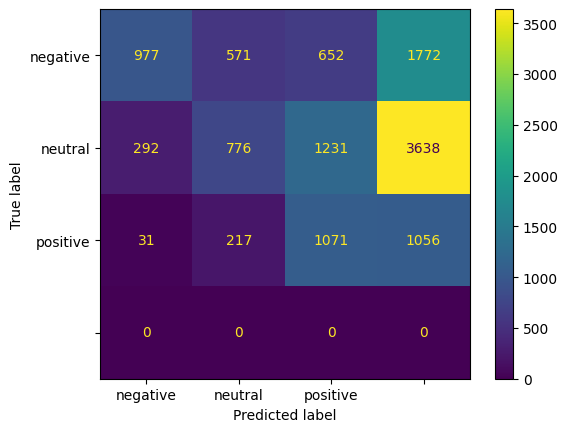

In [ ]:
qlora_large_model = eval(model, dataset["test"], tokenizer)
print(f"QLoRA F1 large model: {qlora_large_model:.2f}")

In [ ]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-tinyllama-qlora")
tokenizer.push_to_hub(f"{REPO_NAME}-tinyllamma-qlora")

adapter_model.safetensors: 100%|██████████| 3.26M/3.26M [00:01<00:00, 2.73MB/s]
tokenizer.model: 100%|██████████| 500k/500k [00:00<00:00, 1.03MB/s]


CommitInfo(commit_url='https://huggingface.co/gsemenyak/llm-course-hw3-tinyllamma-qlora/commit/cda10fc4c68d0c86377f33947a4e52267b921415', commit_message='Upload tokenizer', commit_description='', oid='cda10fc4c68d0c86377f33947a4e52267b921415', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gsemenyak/llm-course-hw3-tinyllamma-qlora', endpoint='https://huggingface.co', repo_type='model', repo_id='gsemenyak/llm-course-hw3-tinyllamma-qlora'), pr_revision=None, pr_num=None)

# Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Оформить репозитории на 🤗 (можно сделать коллекцию, так как у нас 3 репозитория): карточка модели с описанием задания, репортом качества и примерами генерации **[2 балла]**

# Специальный раздел для проверяющего

## LoRA

In [ ]:
from safetensors.torch import load_file
from huggingface_hub import hf_hub_download

model = AutoModelForCausalLM.from_pretrained(f"{REPO_NAME}-lora", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(f"{REPO_NAME}-lora")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Примените peft к модели
apply_peft_to_module(model, LinearWithLoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])
model.to(DEVICE)

path = hf_hub_download(f"{REPO_NAME}-lora", "model.safetensors")
state_dict = load_file(path)

model.load_state_dict(state_dict, strict=False)

LoRA_saved_model_accuracy = eval(model, dataset["test"], tokenizer)
print(f"Accuracy after LoRA training: {LoRA_saved_model_accuracy:.2f}")

## DoRA

In [ ]:
model = AutoModelForCausalLM.from_pretrained(f"{REPO_NAME}-dora", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(f"{REPO_NAME}-dora")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

apply_peft_to_module(model, LinearWithDoRA, r=8, alpha=16, target_submodules=["k_proj", "v_proj"])
model.to(DEVICE)

path = hf_hub_download(f"{REPO_NAME}-dora", "model.safetensors")
state_dict = load_file(path)

model.load_state_dict(state_dict, strict=False)

DoRA_saved_model_accuracy = eval(model, dataset["test"], tokenizer)
print(f"Accuracy after DoRA training: {DoRA_saved_model_accuracy}")

## QLoRA

In [ ]:
model = AutoModelForCausalLM.from_pretrained(f"{REPO_NAME}-tinyllama-qlora", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(f"{REPO_NAME}-tinyllama-qlora")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

QLoRA_saved_model_accuracy = eval(model, dataset["test"], tokenizer)
print(f"Accuracy after tinyllama QLoRA training: {QLoRA_saved_model_accuracy}")